# Introduzione ai modelli di clustering
Gli algoritmi di regressione visti finora fanno parte del sottoinsieme del machine-learning detto *supervised learning* (apprendimento supervisionato), in quanto stiamo mostrando all'algoritmo un obbiettivo definito dalla nostra variabile target (e.g. stiamo indicando in fase di training quali tiri sono gol). Esistono anche algoritmi di *unsupervised learning*, dove l'obbiettivo di apprendimento dell'algoritmo non è definito in modo esplicito. Questa categoria include gli algoritmi di clustering, che consistono nel raggruppare i dati in base alle variabili a disposizione.

In [22]:
!pip install distutils

ERROR: Could not find a version that satisfies the requirement distutils (from versions: none)
ERROR: No matching distribution found for distutils


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from database.read_db import *

ModuleNotFoundError: No module named 'distutils'

Andiamo a leggere un dataset pensato appositamente per creare un modello di clustering semplificato di identificazione di ruoli/funzioni in campo. Essendo interessati a _cosa_ fa il giocatore in campo piuttosto che a _quanto bene_ lo faccia, andremo a normalizzare i nostri dati non per 90 minuti ma per 100 tocchi, nel tentativo di rimuovere il bias dovuto al fatto di giocare in squadre più o meno dominanti.

In [27]:
df = read_db('ds.player_stats_clustering').set_index(['player_id', 'team_id'])
df.head(5)

,,full_name,team,soccRole,mins_played,touches,open_play_pass,total_long_balls,total_dribbles,total_offside,header_shots,...,poss_won_mid_3rd,poss_won_att_3rd,total_final_third_passes,passes_into_box,touches_in_opp_box,was_fouled,progressive_passes,progressive_carries,op_cross,total_cutback
player_id,team_id,,,,,,,,,,,,,,,,,,,,,
12473,603,Fabio Quagliarella,Sampdoria,FW,796,367,209,29,7.0,6.0,5.0,...,17.0,6.0,107,24.0,47.0,19.0,11,2,14.0,0.0
19620,126,Miguel Veloso,Verona,CM,1167,748,485,99,6.0,1.0,0.0,...,62.0,7.0,163,82.0,6.0,8.0,38,3,26.0,0.0
21125,123,Lorenzo De Silvestri,Bologna,FB,668,498,345,29,3.0,2.0,3.0,...,13.0,2.0,87,20.0,7.0,6.0,15,7,7.0,0.0
28277,128,Leonardo Bonucci,Juventus,CB,875,669,539,81,1.0,1.0,3.0,...,26.0,0.0,61,8.0,7.0,5.0,48,2,0.0,0.0
38943,2174,Daniel Ciofani,Cremonese,FW,1054,332,183,9,4.0,6.0,12.0,...,16.0,9.0,115,18.0,55.0,15.0,5,4,2.0,0.0


In [28]:
for c in df.select_dtypes(np.number).columns.to_list():
    if c not in ['mins_played', 'touches', 'full_name', 'team', 'soccRole']:
        df[f'{c}_p100'] = df[c] / df.touches * 100

# K-means clustering
Per semplicità, come primo esempio selezioniamo solo difensori centrali e terzini, e usiamo due statistiche che sono già sufficienti per distinguerli, come cross e spazzate.

In [29]:
df2 = df[df.soccRole.isin(['CB', 'FB'])]

<Axes: xlabel='op_cross_p100', ylabel='total_clearance_p100'>

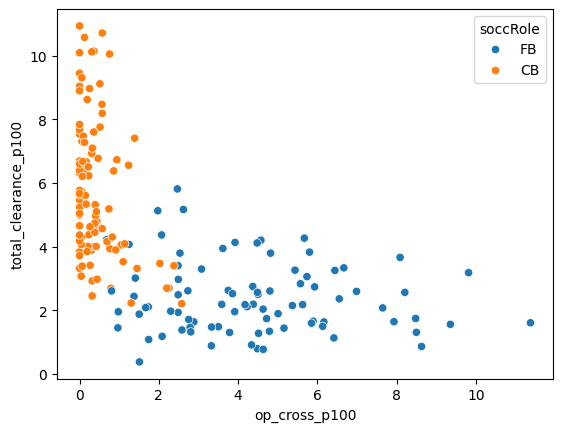

In [30]:
sns.scatterplot(data = df2, x = 'op_cross_p100', y = 'total_clearance_p100', hue = 'soccRole')

Vediamo che i due gruppi sono abbastanza distinti, e ci sono alcuni giocatori che sembrano classificati in modo errato, forse per via della fluidità di ruolo che esiste in alcuni casi fra terzi centrali di difesa e esterni. Vediamo come applicare un semplice algoritmo di clustering a questo caso. L'algoritmo più semplice e diffuso in questo ambito è sicuramente il *k-means clustering*. Questo algoritmo si sviluppa in modo iterativo:
* Assegnazione dei centroidi di cluster
* Assegnazione dei punti al cluster con centro più vicino
* Riassegnazione del centroide dei cluster in base alla posizione media dei punti

Questo ciclo viene ripetuto finché le assegnazioni dei punti ai diversi cluster non variano più. Nell'animazione seguente (credit: Wikipedia) vediamo un esempio del processo con tre cluster.


È importante tenere a mente le principali limitazioni di questo modello:
* Il numero di cluster va impostato, introducendo un bias nell'analisi nei casi in cui non si ha una classificazione di riferimento
* L'algoritmo tende a ricercare cluster di forma circolare (essendo basato solo sulla distanza dal centro) e di dimensioni simili

Il risultato del modello andrà quindi sempre visto con un occhio particolarmente critico.

Proviamo ad applicare l'algoritmo al nostro caso semplificato. Per prima cosa selezioniamo i dati, scegliendo quindi le variabili viste prima.

In [31]:
X = df2[['op_cross_p100', 'total_clearance_p100']].values

Andiamo ad applicare l'algoritmo impostando il numero di cluster pari a 2

In [32]:
kmeans = KMeans(n_clusters=2, n_init = 'auto', random_state=0).fit(X)

Andiamo quindi ad assegnare le etichette di cluster risultanti ai nostri dati, e a visualizzarli.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\382880038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clusters'] = kmeans.labels_


<Axes: xlabel='op_cross_p100', ylabel='total_clearance_p100'>

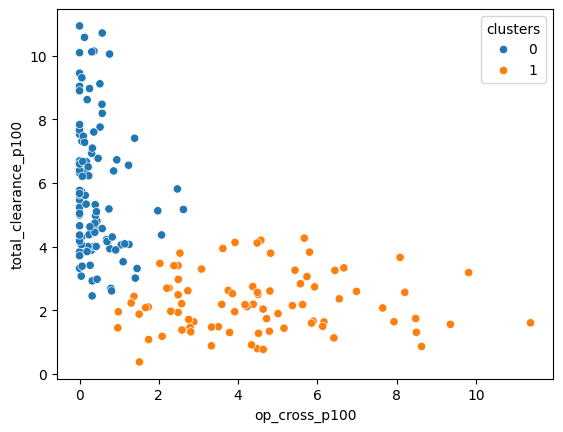

In [33]:
df2['clusters'] = kmeans.labels_
sns.scatterplot(data = df2, x = 'op_cross_p100', y = 'total_clearance_p100', hue = 'clusters')

Vediamo che l'algoritmo sembra aver separato correttamente i due gruppi. Come possiamo valutare la performance in questo caso? Nel caso in cui siamo convinti di avere una classificazione di riferimento corretta, ossia se nel nostro caso siamo convinti che il modello abbia come obbiettivo proprio il soccRole come compare nei nostri dati, possiamo per esempio usare  come score il cosiddetto *Adjusted Rand Index*. Dobbiamo prima convertire la nostra informazione sul ruolo in un label corrispondente a quello fornito dal clustering.

In [35]:
df2['label'] = (df2.soccRole == 'FB').astype(int)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\2749509154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label'] = (df2.soccRole == 'FB').astype(int)


In [36]:
adjusted_rand_score(df2.label, df2.clusters)

0.7186843052803331

Questo score valuta la similarità fra le due assegnazioni, e confronta il nostro modello con un'assegnazione casuale dei labels. Il valore risultante è compreso fra -1 e +1, dove valori negativi indicano che il nostro modello fa peggio di un'assegnazione casuale, e valori positivi indicano una buona corrispondenza.

Se invece vogliamo rimanere "neutrali" sulla corretta assegnazione dei nostri dati (per necessità o per scelta), possiamo usare metriche che si focalizzano sulla struttura dei cluster e la loro coerenza interna, come il *silhouette score*. Questa metrica, anch'essa compresa fra -1 e +1, valuta positivamente cluster compatti e ben separati, confrontando la distanza fra punti nello stesso cluster con quella da punti in altri cluster.

In [37]:
silhouette_score(X, df2.clusters)

0.5126891786165172

# Soft/fuzzy clustering: Gaussian Mixture
In molti casi, non è sufficiente avere un modello che restituisca un label per i nostri cluster, ma è rilevante avere un'informazione di tipo probabilistico. Inoltre, nella maggior parte dei casi è preferibile andare a creare cluster di forma arbitraria. Infine, dover inserire in input il numero di cluster non è affatto ideale nel caso in cui vogliamo trovare delle nuove classi, piuttosto che modellare delle classi note.

Per quanto riguarda il primo punto, esistono diverse opzioni di algoritmi che restituiscono una probabilità di classificazione e non solo un label: un esempio tipico è il modello di *Gaussian Mixture* (o GMM), che cerca di modellare il dataset con una combinazione di funzioni gaussiane.

I modelli di tipo GMM forniscono già un miglioramento rispetto a K-means anche riguardo il secondo punto, ossia la forma dei cluster. Su questo aspetto, ci sono però altri algoritmi più focalizzati sulla ricostruzione di cluster ben separati ma di forma arbitraria, che vanno a formare la famiglia di *density-based clustering*, di cui l'implementazione più nota è *DBSCAN*. Lo svantaggio principale di questo tipo di modelli è la maggiore complessità e quindi minore spiegabilità, e la tendenza a classificare molti punti in aree considerate a bassa densità come rumore, non assegnandogli quindi un cluster. Inoltre nella sua versione di default DBSCAN non fornisce probabilità di classificazione.

Infine, per quanto riguarda il terzo punto, sia GMM che DBSCAN forniscono una soluzione in modo diverso: GMM richiede un numero di cluster in input, ma in alcune varianti (Bayesian Gaussian Mixture) va poi ad assegnare dei pesi, di fatto mettendo a zero il peso di cluster che ritiene non necessari. DBSCAN invece stabilisce il numero di cluster in modo autonomo, senza richiederlo in input.

L'implementazione di questi metodi in Scikit-learn è ampiamente documentata sulle pagine di aiuto della libreria:
https://scikit-learn.org/stable/modules/clustering.html

Proviamo ad applicare un modello GMM semplice all'esempio visto prima.

In [38]:
gm = GaussianMixture(n_components=2, random_state=0).fit(X)

df2['gm_cluster'] = gm.predict(X)
df2['gm_cluster_prob0'] = gm.predict_proba(X)[:,0]
df2['gm_cluster_prob1'] = gm.predict_proba(X)[:,1]

C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\3878030610.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['gm_cluster'] = gm.predict(X)
C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\3878030610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['gm_cluster_prob0'] = gm.predict_proba(X)[:,0]
C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\3878030610.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

<Axes: xlabel='op_cross_p100', ylabel='total_clearance_p100'>

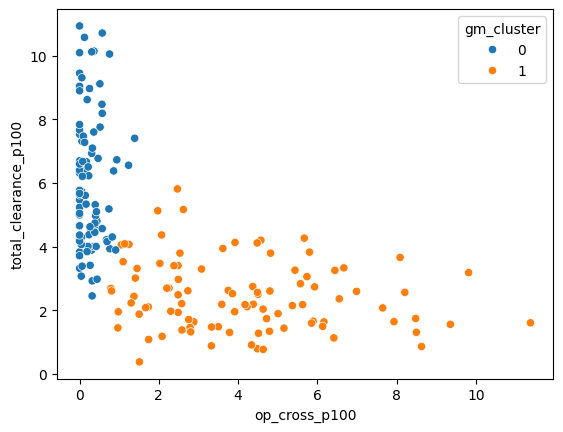

In [39]:
sns.scatterplot(data = df2, x = 'op_cross_p100', y = 'total_clearance_p100', hue = 'gm_cluster')

Vediamo che anche qui il risultato sembra buono, anche se è leggermente diverso da quello ottenuto con K-means. L'aspetto interessante di questo modello è che abbiamo estratto tramite `predict_proba` le nostre probabilità di classificazione, oltre a i label, e questo ci permette di andare a vedere se ci sono casi di giocatori ibridi.

In [41]:
df2[['full_name', 'gm_cluster', 'gm_cluster_prob0', 'gm_cluster_prob1']]

,,full_name,gm_cluster,gm_cluster_prob0,gm_cluster_prob1
player_id,team_id,,,,
21125,123,Lorenzo De Silvestri,1,0.005329,9.946714e-01
28277,128,Leonardo Bonucci,0,0.938618,6.138163e-02
39826,127,Danilo D'Ambrosio,1,0.005624,9.943757e-01
40002,127,Matteo Darmian,1,0.000047,9.999533e-01
40792,1025,Federico Fazio,0,1.000000,4.469291e-07
...,...,...,...,...,...
519394,456,Giorgio Scalvini,0,0.776358,2.236420e-01
523991,126,Isak Hien,0,0.999098,9.024685e-04
543612,128,Federico Gatti,0,0.971182,2.881808e-02


Vediamo di chi si tratta andando a filtrare per giocatori dove la probabilità massima per entrambi i cluster è meno di due terzi.

In [48]:
#isoliamo giocatori ibridi
df2['hybrid'] = df2[['gm_cluster_prob0', 'gm_cluster_prob1']].max(axis = 1) < 2/3

C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\2170106010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hybrid'] = df2[['gm_cluster_prob0', 'gm_cluster_prob1']].max(axis = 1) < 2/3


In [49]:
df2[df2.hybrid][['full_name', 'soccRole', 'gm_cluster', 'gm_cluster_prob0', 'gm_cluster_prob1']]

,,full_name,soccRole,gm_cluster,gm_cluster_prob0,gm_cluster_prob1
player_id,team_id,,,,,
61118,456,Rafael Tolói,CB,1,0.350676,0.649324
89861,456,José Palomino,CB,1,0.442821,0.557179
169107,129,Adam Marusic,FB,1,0.411793,0.588207
214286,2036,Dimitrios Nikolaou,CB,0,0.545231,0.454769


# Generalizzazione a più dimensioni
Tutti questi concetti e algoritmi che abbiamo visto sono applicabili a dati con più di due dimensioni con lo stesso processo. Proviamo a generalizzare la nostra analisi includendo più variabili, e introducendo anche un passaggio di standardizzazione. Questo aiuterà l'algoritmo andando a trasformare tutte le statistiche in un range simile di valori. Matematicamente, l'operazione consiste nel sottrarre ad ogni statistica la media, e dividere per la deviazione standard. Questa operazione viene svolta dalla funzione `StandardScaler` di scikit-learn.

In [50]:
#standardizziamo i dati

vars = [x for x in df.columns if x.endswith('_p100')]

scaler = StandardScaler()
dfs = pd.DataFrame(scaler.fit_transform(df[vars].values), index = df.index, columns = vars)
dfs[['full_name', 'soccRole']] = df[['full_name', 'soccRole']]

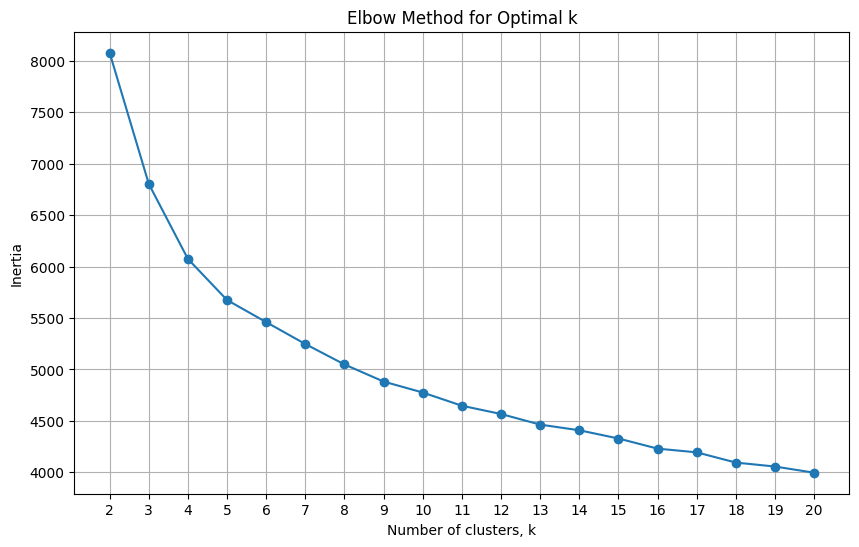

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming dfs[vars].values is your data matrix X
X = dfs[vars].values

# Range of k values
k_range = range(2, 21)

# List to store the inertias for each k
inertias = []

for k in k_range:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(X)
    inertias.append(model.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In questo caso è chiaro che non sappiamo che numero di cluster utilizzare. Per avere una prima stima, possiamo utilizzare il cosiddetto metodo del gomito (*elbow method*). L'idea è di provare modelli con un diverso numero di cluster e andare a confrontarne gli score (in questo caso la somma del quadrato delle distanze di ogni punto dal centro del cluster), selezionando quello oltre il quale lo score smette di migliorare sensibilmente. Questo processo è implementato in modo molto pratico nella libreria `yellowbrick`, tramite la funzione `KElbowVisualizer`.

In [55]:
# X = dfs[vars].values

# model = KMeans(n_init = 'auto')
# visualizer = KElbowVisualizer(model,
#                               k=(2,20), 
#                               timings = False)
# visualizer.fit(X)
# visualizer.show()

Vediamo come varia lo score in funzione del numero di cluster $k$. In questo caso l'algoritmo suggerisce 6 gruppi, ma il "gomito" non è così netto. In generale è meglio validare questo risultato usando altri metodi, uno dei quali è basato proprio sullo Silhouette score, ed è implementato sempre nella libreria `yellowbricks`.

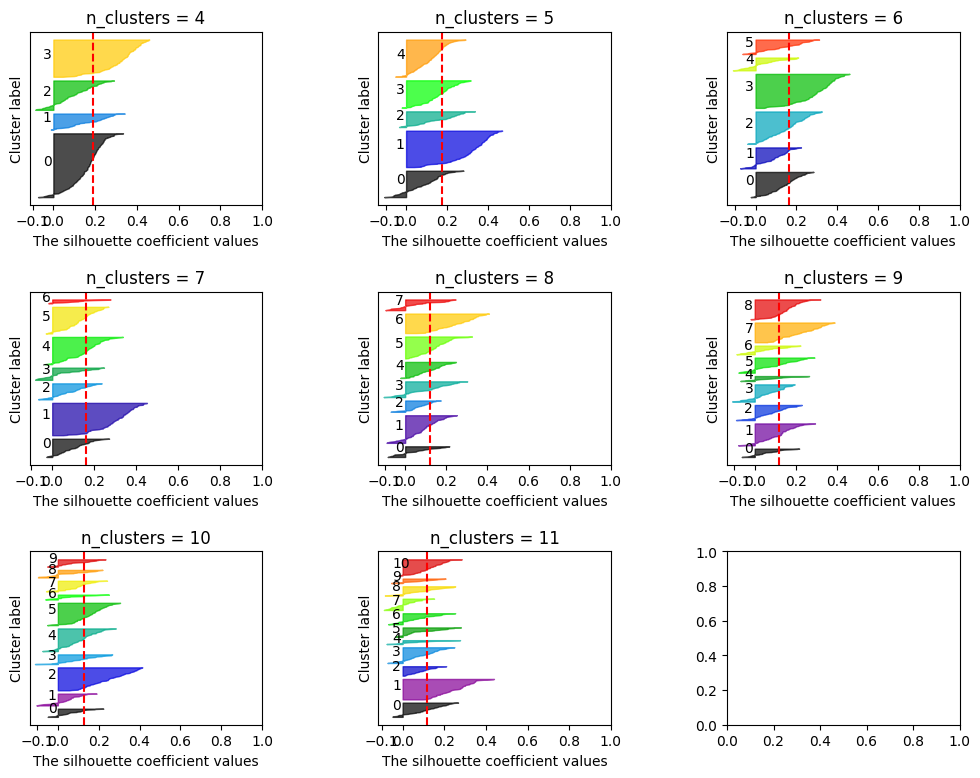

In [69]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# Assuming dfs[vars].values is your data matrix X
X = dfs[vars].values

fig, axs = plt.subplots(3, 3, figsize=(12, 9))  # Set up the plot grid

range_n_clusters = range(4, 12)  # Clusters from 4 to 11

for i, k in enumerate(range_n_clusters):
    ax = axs.ravel()[i]  # Get the subplot for the current k

    # Create a KMeans instance with k clusters and fit the model
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    cluster_labels = km.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for j in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster j, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()

        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

    ax.set_title(f'n_clusters = {k}')
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust the space between plots
plt.show()


Questi grafici mostrano la distribuzione del Silhouette score dei dati nei vari cluster, insieme al valore medio. In linea di massima un numero ottimale di cluster vedrebbe tutti i cluster superare il valore medio (indicato dalla linea verticale), e una distribuzione di valori abbastanza uniforme all'interno dei cluster. In questo caso vediamo che il modello non è particolarmente qualitativo, ma troviamo conferma del valore k=6 indicato dal metodo del gomito.

Proviamo ora a creare i cluster con l'algoritmo di Gaussian Mixture.

In [62]:
ncomp = 7
gm = GaussianMixture(n_components=ncomp, random_state=0).fit(X)

dfs['gm_cluster'] = gm.predict(X)
for i in range(0,ncomp):
  dfs[f'gm_cluster_prob{i}'] = gm.predict_proba(X)[:,i]

Per capire che tipo di raggruppamento abbiamo ottenuto, andiamo a vedere le statistiche mediane per i vari cluster.

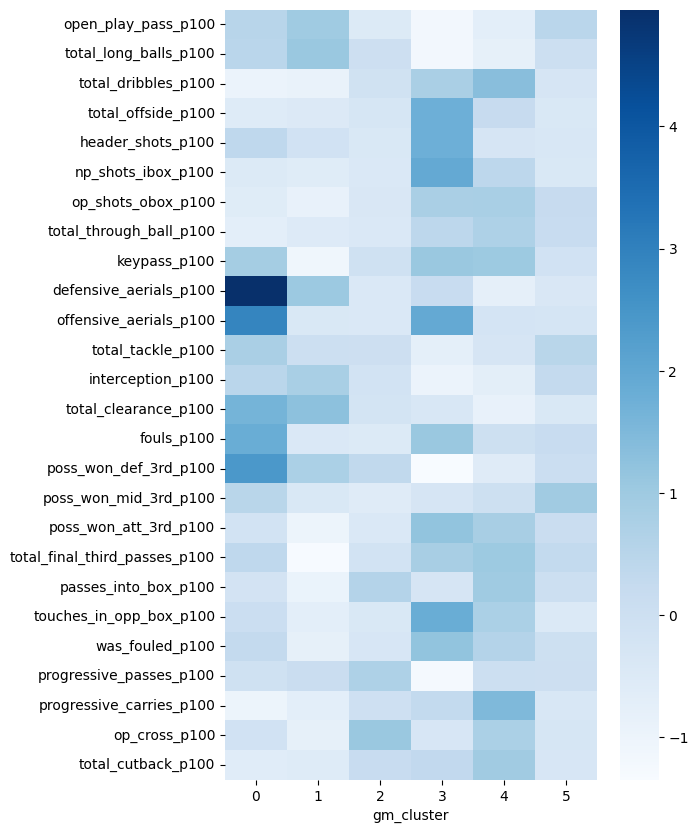

In [57]:
dfsg = dfs.groupby('gm_cluster')[vars].mean()

plt.figure(figsize = (6,10))
sns.heatmap(dfsg.T, cmap = 'Blues')
plt.show()

In [58]:
for cluster in range(0, ncomp):
    print(dfs[dfs.gm_cluster == cluster].sort_values(f'gm_cluster_prob{cluster}', ascending = False)[['full_name', 'soccRole', f'gm_cluster_prob{cluster}']].head(10))

                           full_name soccRole  gm_cluster_prob0
player_id team_id                                              
213602    126      Oliver Abildgaard       CM               1.0
                           full_name soccRole  gm_cluster_prob1
player_id team_id                                              
28277     128       Leonardo Bonucci       CB               1.0
209736    125         Lucas Martínez       CB               1.0
248881    695         Koni De Winter       CB               1.0
235001    742         Valentin Antov       CB               1.0
229912    695         Ardian Ismajli       CB               1.0
223203    135           Perr Schuurs       CB               1.0
220872    135      Andreaw Gravillon       CB               1.0
215979    120          Matteo Gabbia       CB               1.0
211265    2174      Luka Lochoshvili       CB               1.0
204631    2182          Martin Erlic       CB               1.0
                              full_name 

In questo caso non è possibile andare a visualizzare in modo diretto la divisione fra i cluster come fatto in precedenza, dovendo trattare con più di due variabili. Per poterlo fare, dobbiamo applicare un algoritmo di *riduzione di dimensionalità*, che consiste nel trovare una rapprentazione che catturi e "comprima" le caratteristiche principali dei dati in meno variabili. Anche qui ci sono diversi tipi di algoritmo che si possono usare, fra cui il più noto è la cosiddetta *Principal Component Analysis*, o PCA. A livello matematico, questo algoritmo cerca di ridurre il dataset a un numero minore di variabili indipendenti, sfruttando il fatto che almeno alcune delle variabili originali hanno tipicamente un certo livello di correlazione fra loro. Vediamo come applicarlo nella sua implementazione all'interno di Scikit-learn, in questo caso inserendo esplicitamente il numero di dimensioni voluto.

In [63]:
#fit del modello PCA
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X)

In [64]:
#inserimento coordinate nel dataframe
dfs[['c1', 'c2']] = X_transformed

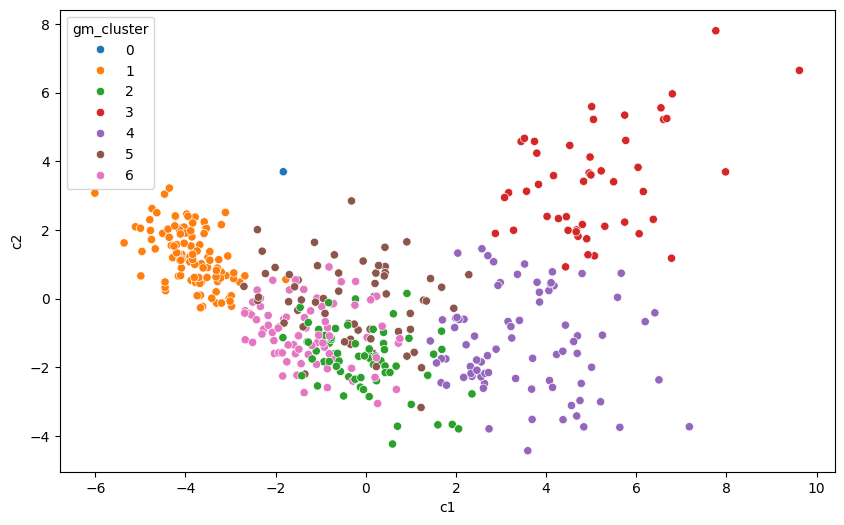

In [65]:
#trasformazione label cluster in stringa (categorico)
dfs['gm_cluster'] = dfs.gm_cluster.astype(str)

#scatterplot
f, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data = dfs, x = 'c1', y = 'c2', hue = 'gm_cluster', hue_order = np.arange(0,ncomp).astype(str), ax = ax)
plt.show()

Vediamo che la divisione fra i cluster rimane più o meno visibile anche dopo questo passaggio, ma ci sono sovrapposizioni fra i cluster dovute al fatto che la riduzione di dimensionalità è comunque una rappresentazione semplificata e non completa dei dati.

Nel caso di un numero molto elevato di variabili, può essere necessario operare il passaggio di riduzione di dimensionalità prima di applicare il clustering, in quanto in uno spazio con molte dimensione le distanze fra i singoli punti tendono a dilatarsi. D'altro canto questo permette anche, in caso sia possibile rappresentare il dataset in due dimensioni, di costruire un modello visualizzabile in modo più intuitivo. Naturalmente in questo caso va verificato tramite le proprie conoscenze calcistiche che la struttura risultante abbia senso.

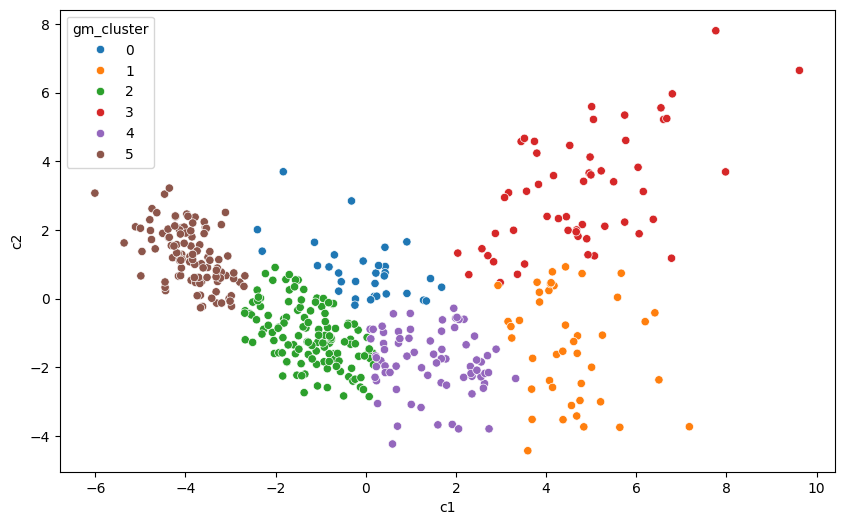

In [68]:
#clustering dopo PCA
ncomp = 6
dfs2 = dfs.copy()
gm = GaussianMixture(n_components=ncomp, random_state=0).fit(X_transformed)

dfs2['gm_cluster'] = gm.predict(X_transformed)
for i in range(0,ncomp):
  dfs2[f'gm_cluster_prob{i}'] = gm.predict_proba(X_transformed)[:,i]

#trasformazione label cluster in stringa (categorico)
dfs2['gm_cluster'] = dfs2.gm_cluster.astype(str)

#scatterplot
f, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data = dfs2, x = 'c1', y = 'c2', hue = 'gm_cluster', hue_order = np.arange(0,ncomp).astype(str), ax = ax)
plt.show()

In [67]:
for cluster in range(0, ncomp):
    print(dfs2[dfs2.gm_cluster == str(cluster)].sort_values(f'gm_cluster_prob{cluster}', ascending = False)[['full_name', 'soccRole', f'gm_cluster_prob{cluster}']].head(20))

                              full_name soccRole  gm_cluster_prob0
player_id team_id                                                 
213602    126         Oliver Abildgaard       CM          0.999953
90594     742             Mattia Valoti       CM          0.992357
201392    130               Alexis Blin       CM          0.988206
459025    120            Tommaso Pobega       CM          0.974885
550095    695            Jacopo Fazzini       CM          0.951366
232066    130             Youssef Maleh       CM          0.944802
66247     136          Marvin Zeegelaar       FB          0.929489
439492    123            Lewis Ferguson      CAM          0.916464
198381    2174           Charles Pickel       CM          0.908355
450048    130      Kristoffer Askildsen       CM          0.907860
164570    456             Mario Pasalic      CAM          0.897686
171152    127       Roberto Gagliardini       CM          0.888986
184847    2036         Viktor Kovalenko       CM          0.86